<h1>BBC news article clustering using Non-Zero Matrix Factorization (NMF)</h1>

<h2>Part 1:<p></p>Extracting word features and show Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)</h2>

<h3>Libraries</h3>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns

from sklearn.model_selection import ParameterGrid
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, MiniBatchNMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

C:\Users\kgrit\AppData\Local\Temp\ipykernel_30520\2838834717.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kgrit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df_train = pd.read_csv('data/BBC News Train.csv')
df_test = pd.read_csv('data/BBC News Test.csv')
df_solution = pd.read_csv('data/BBC News Sample Solution.csv')

<hr><p>Below is a quick preview of the contents of the three dataframes, shown using .head(), .info() and when possible the .Category.value_counts() to see how many instances of each type of article category are present</p><hr>

In [3]:
display(df_train.head())
display(df_train.Category.value_counts())
print()
display(df_train.info())
display(df_train.iloc[0]['Text'])

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB


None

'worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebb

<hr>
<p>We can see from the information above that there is a somewhat uniform distribution of article category counts, with sports and business being the most represented. Also, the article data itself appears to be quite clean, at least in the very first article present in the train dataframe.</p><hr>

In [4]:
display(df_test.head())
display(df_test.info())

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


None

In [5]:
display(df_solution.head())
display(df_solution.Category.value_counts())
print()
display(df_solution.info())

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,business
3,459,entertainment
4,1020,politics


Category
sport            147
tech             147
business         147
entertainment    147
politics         147
Name: count, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Category   735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


None

<hr><p>From the inspection of the dataframes, it appears that little data cleaning will be needed before explore patterns within it, though it is best to still perform some in case there are stray symbols and text characters that could mess up future tasks. To do that, we can use regular expressions to remove characters that dont correspond to the english alphabet or integers 0 thorugh 9, using the function clean_article_text() below. This will be done to both the train and test dataframes.</p><p>clean_article_text() first drops the entire article text to lower case, then performs a regular expression on the text to remove all non-alphanumeric characters, then strips the remaining text of all unimportant words ('stopwords') like 'is', 'the', 'and', etc.</p><hr>

In [6]:
def clean_article_text(article):
    
    article = article.lower()
    article = re.sub('[^a-z A-Z 0-9-]+', '', article)
    article = " ".join([word for word in article.split() if word not in stopwords.words('english')])
    
    return article

In [7]:
df_train['Text_clean'] = df_train['Text']#.apply(clean_article_text)
df_test['Text_clean'] = df_test['Text']#.apply(clean_article_text)

<hr><p>Next, using a histogram plot, we will see the distribution of articles based on their lengths (number of characters) and their word counts. To get this info, we simply take an article text and measure its length - for article length - or split it into an array, and count the number of indecies in the array - for word count.</p><hr>

In [8]:
df_eda = df_train.copy()

In [9]:
df_eda['article_length'] = df_eda['Text_clean'].str.len()

def word_count(article):
    article_word_list = article.split()
    return len(article_word_list)

df_eda['article_word_count'] = df_train['Text_clean'].apply(word_count)
display(df_eda.head())

,ArticleId,Text,Category,Text_clean,article_length,article_word_count
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom ex-boss launches defence lawyers defe...,1866,301
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...,2016,325
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens in ...,3104,514
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster bett...,3618,634
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses in $168m payout eighteen former e...,2190,355


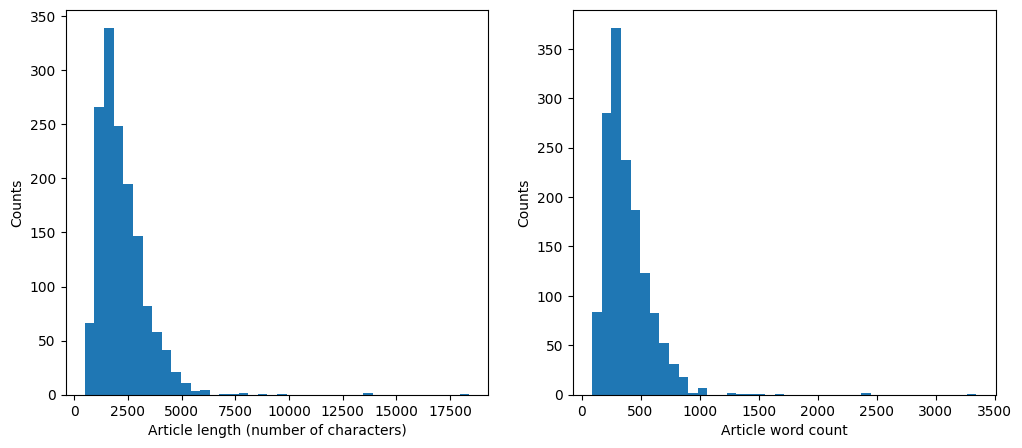

In [10]:
_num_bins = 40

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.hist(df_eda['article_length'], bins=_num_bins)
ax1.set_xlabel('Article length (number of characters)')
ax1.set_ylabel('Counts')
ax2.hist(df_eda['article_word_count'], bins=_num_bins)
ax2.set_ylabel('Counts')
ax2.set_xlabel('Article word count')

plt.show()

<hr><p>Now that we have the plots, we can see that word counts appear to follow the same trend as text lengths, which is not surprising. Note the difference in counts between article length and article word counts.</p><hr><p>To wrap up the EDA, we'll look last at the first 10 articles and find the most common words (monograms), bigrams, and trigrams. N-grams are instances of one or more words that immediataly follow each other, like "economy" (monogram), "final goal" (bigrams), or "mr erikson said" (trigram). Inspiration for this analysis from Harsh Singh [<a href="id01">1</a>].</p><p>The function to do this task is defined below.</p>
<p>get_ngram_freq() takes a cleaned article and transforms the data into a sparse array of ngram counts, whic can be just monograms, just bigrams, or both monograms and bigrams. An array counting the times the ngrams appear is then created, without loosing the indices of the ngrams. That count array is then used to create a dataframe that stores the ngram text and ngram frequency.</p><hr>

In [11]:
def get_ngram_freq(text_clean, _n1, _n2):
    cv = CountVectorizer(ngram_range=(_n1,_n2))
    ngrams = cv.fit_transform([text_clean])

    count_values = ngrams.toarray().sum(axis=0)
    ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
    ngram_freq.columns = ["freq", "ngram"]
    
    return [ngram_freq["freq"][:20], ngram_freq["ngram"][:20]]

In [12]:
df_eda_first_10 = df_eda.iloc[:10]

In [13]:
df_eda_first_10['Text_monogram'] = df_eda_first_10['Text_clean'].apply(lambda row: get_ngram_freq(row, 1, 1))
df_eda_first_10['Text_bigram'] = df_eda_first_10['Text_clean'].apply(lambda row: get_ngram_freq(row, 2, 2))
df_eda_first_10['Text_trigram'] = df_eda_first_10['Text_clean'].apply(lambda row: get_ngram_freq(row, 3, 3))

C:\Users\kgrit\AppData\Local\Temp\ipykernel_30520\1084074982.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eda_first_10['Text_monogram'] = df_eda_first_10['Text_clean'].apply(lambda row: get_ngram_freq(row, 1, 1))
C:\Users\kgrit\AppData\Local\Temp\ipykernel_30520\1084074982.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eda_first_10['Text_bigram'] = df_eda_first_10['Text_clean'].apply(lambda row: get_ngram_freq(row, 2, 2))
C:\Users\kgrit\AppData\Local\Temp\ipykernel_30520\1084074982.py:3: S

In [14]:
def plot_grams(_row):
    print('\nArticle category:', df_eda_first_10.iloc[_row].Category, '\n')
    fig, ax = plt.subplots(1, 3, sharex=True, figsize=(15, 5), layout="constrained")
    _cols = ['Text_monogram', 'Text_bigram', 'Text_trigram']
    _labels = [['single words', ' words (monogram)'], ['bigrams', 'bigrams'], ['trigrams', 'trigrams']]
    for ind, _col in enumerate(_cols):
    
        _x = df_eda_first_10.iloc[_row][_col][0][::-1]
        _y = df_eda_first_10.iloc[_row][_col][1][::-1]
        ax[ind].barh(_y, _x)
    
        ax[ind].set_title(f'Most common {_labels[ind][0]}')
        ax[ind].set_xlabel('Count')
        ax[ind].set_ylabel(f'Most common {_labels[ind][1]}')
    plt.show()
        

<hr><p>Below you will find 5 different collections of plots, each showing the most common single words, bigrams, and trigrams. Each set of plots corresponds to one article, and each category in the test data is represented by one of the five articles.</p><hr>


Article category: business 



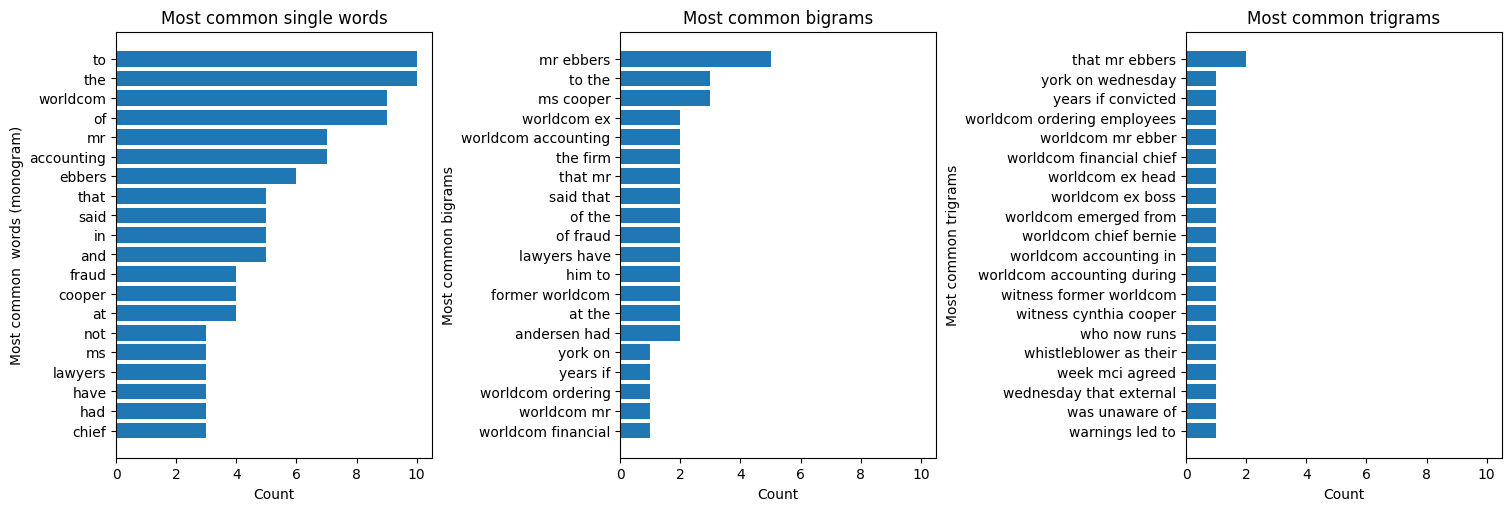

In [15]:
plot_grams(_row = 0)


Article category: tech 



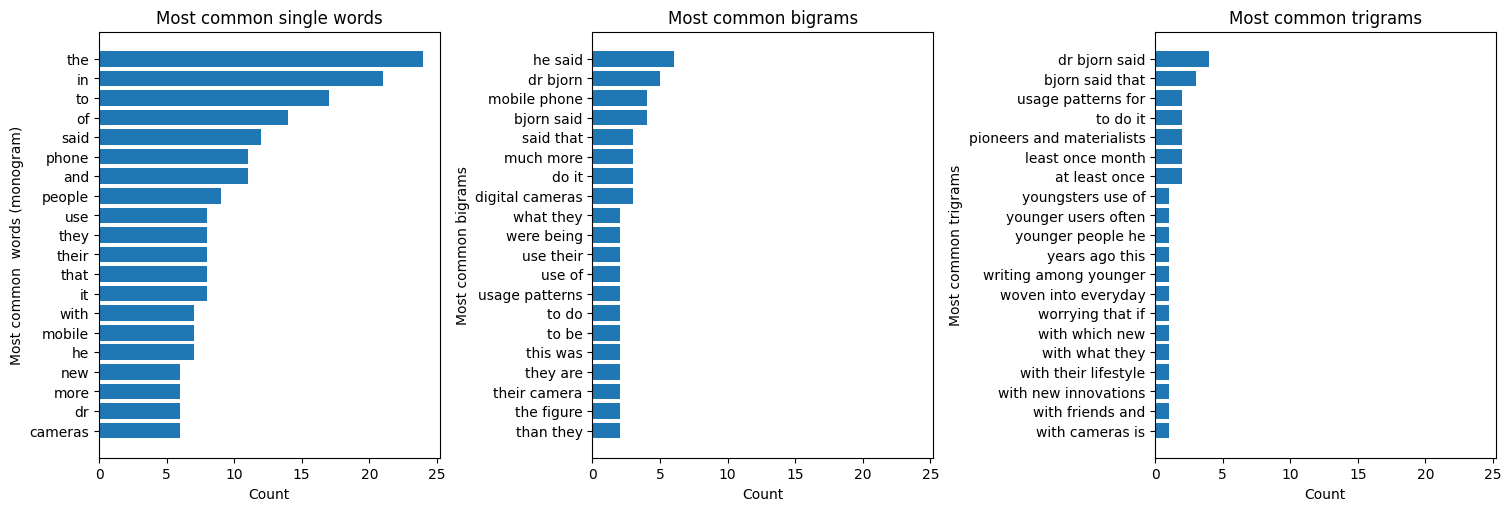

In [16]:
plot_grams(_row = 3)


Article category: politics 



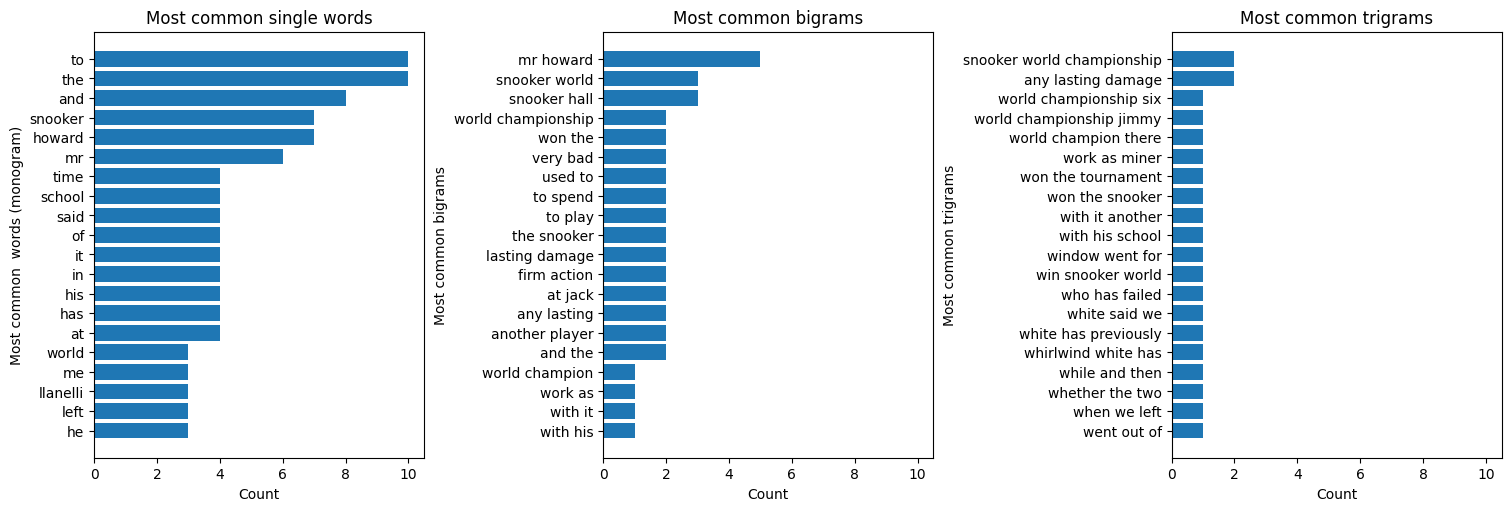

In [17]:
plot_grams(_row = 5)


Article category: sport 



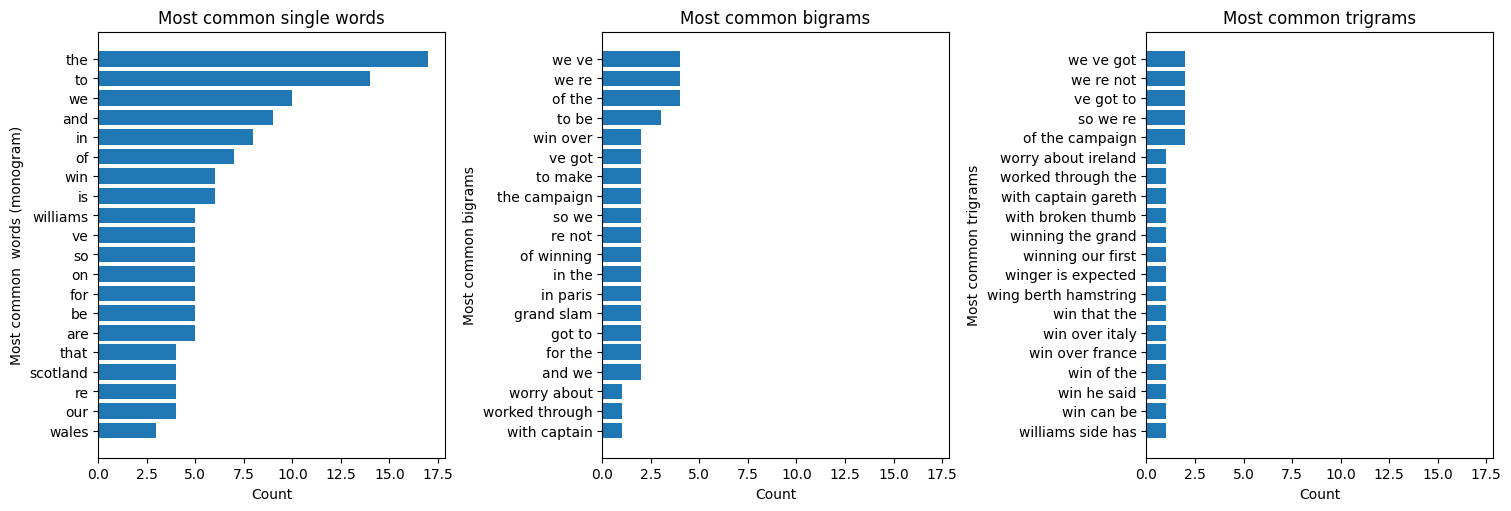

In [18]:
plot_grams(_row = 6)


Article category: entertainment 



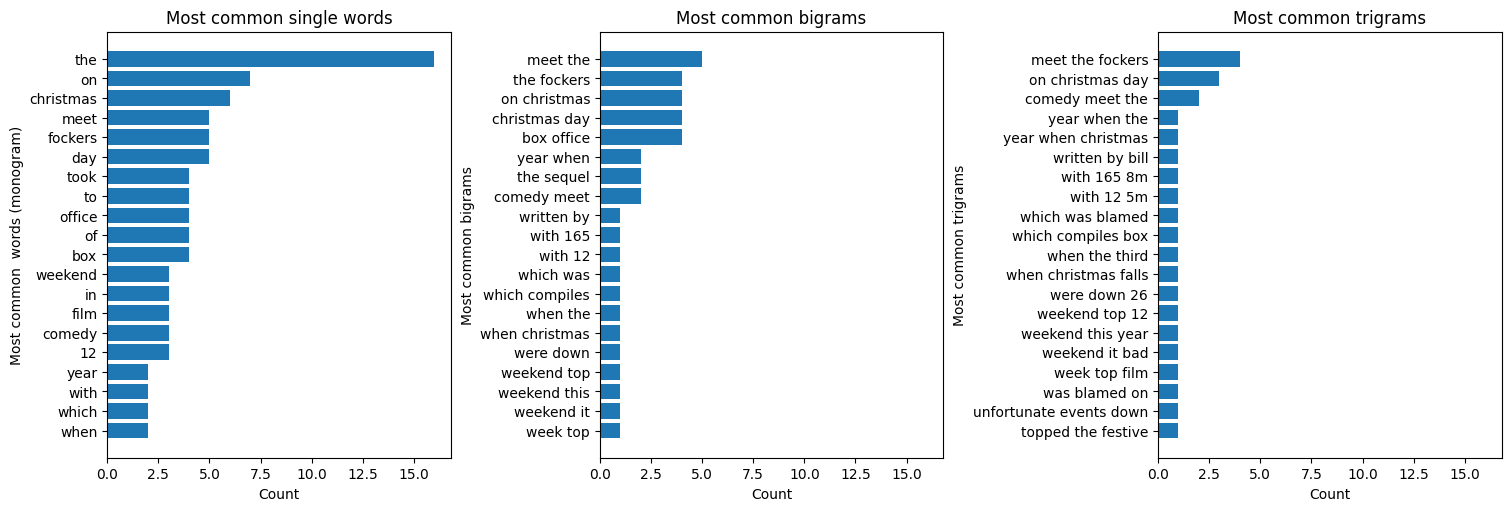

In [19]:
plot_grams(_row = 9)

<hr><p>Just from quick glance at the plots, you can see that bigram and trigram frequencies are very low. From this inspection, articles can have more than one brigram that occurs more than once, but trigrams almost never have a single set of words that appear more than once. This is informative for later unsupervised learning tasks because seeing that trigrams are unlikely means we can focus on single word occurances, bigrams, and mixes of the two.</p><hr>

<h2>Part 2:<p></p>Building and training models</h2>

<hr><p>Question posed in assignment:</p><blockquote>"When you train the unsupervised model for matrix factorization, should you include texts (word features) from the test dataset or not as the input matrix? Why or why not?"</blockquote><p>You should <b>not</b> use a matrix containing the explicit word features as the input matrix. The math of matrix factorization requires the input matrix contain only real numbers at each index. This means that if a corpus of text is going to be processed using matrix factorization, the corpus must first be transformed into an m x n matrix of real numbers with a corresponding dictionary. This dictionary connects the real-valued column elements (features that correspond to transformed counts of words or ngrams) of a row (sample that represents an article text) to the actual words and/or ngrams that appear in the documents.</p><hr>

<h3>Building a model using the matrix factorization methods and predict the train and test data labels. Choose any hyperparameter (e.g., number of word features) to begin with.</h3>

<hr><p>model creation</p><hr>

In [20]:
n_features = 3000
n_components = 5
n_top_words = 20
init = "nndsvda"

final_test, final_test_categories  = df_test['Text_clean'].values, df_solution['Category'].values
X_train, X_validate, y_train, y_validate = train_test_split(df_train['Text_clean'].values, df_train['Category'].values, test_size=0.33, random_state=0)

print(X_train.shape, X_validate.shape, y_train.shape, y_validate.shape )


(998,) (492,) (998,) (492,)


In [21]:

tfidf_inputs = {'max_df':0.95, 'min_df':2, 'max_features':n_features, 'stop_words':"english"}
tfidf_vectorizer_train = TfidfVectorizer(**tfidf_inputs)
tfidf_train = tfidf_vectorizer_train.fit_transform(X_train)

nmf_inputs = {'n_components':n_components, 'random_state':1, 'init':init, 'beta_loss':"frobenius", 'alpha_W':0.001, 'alpha_H':0.001}
nmf = NMF(**nmf_inputs).fit(tfidf_train)

<hr><p>model inspection</p><p>Inspiration for this analysis from SKlearn example pages [<a href="id02">2</a>]</p><hr>

In [72]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.savefig(title + '.png')
    plt.show()
    


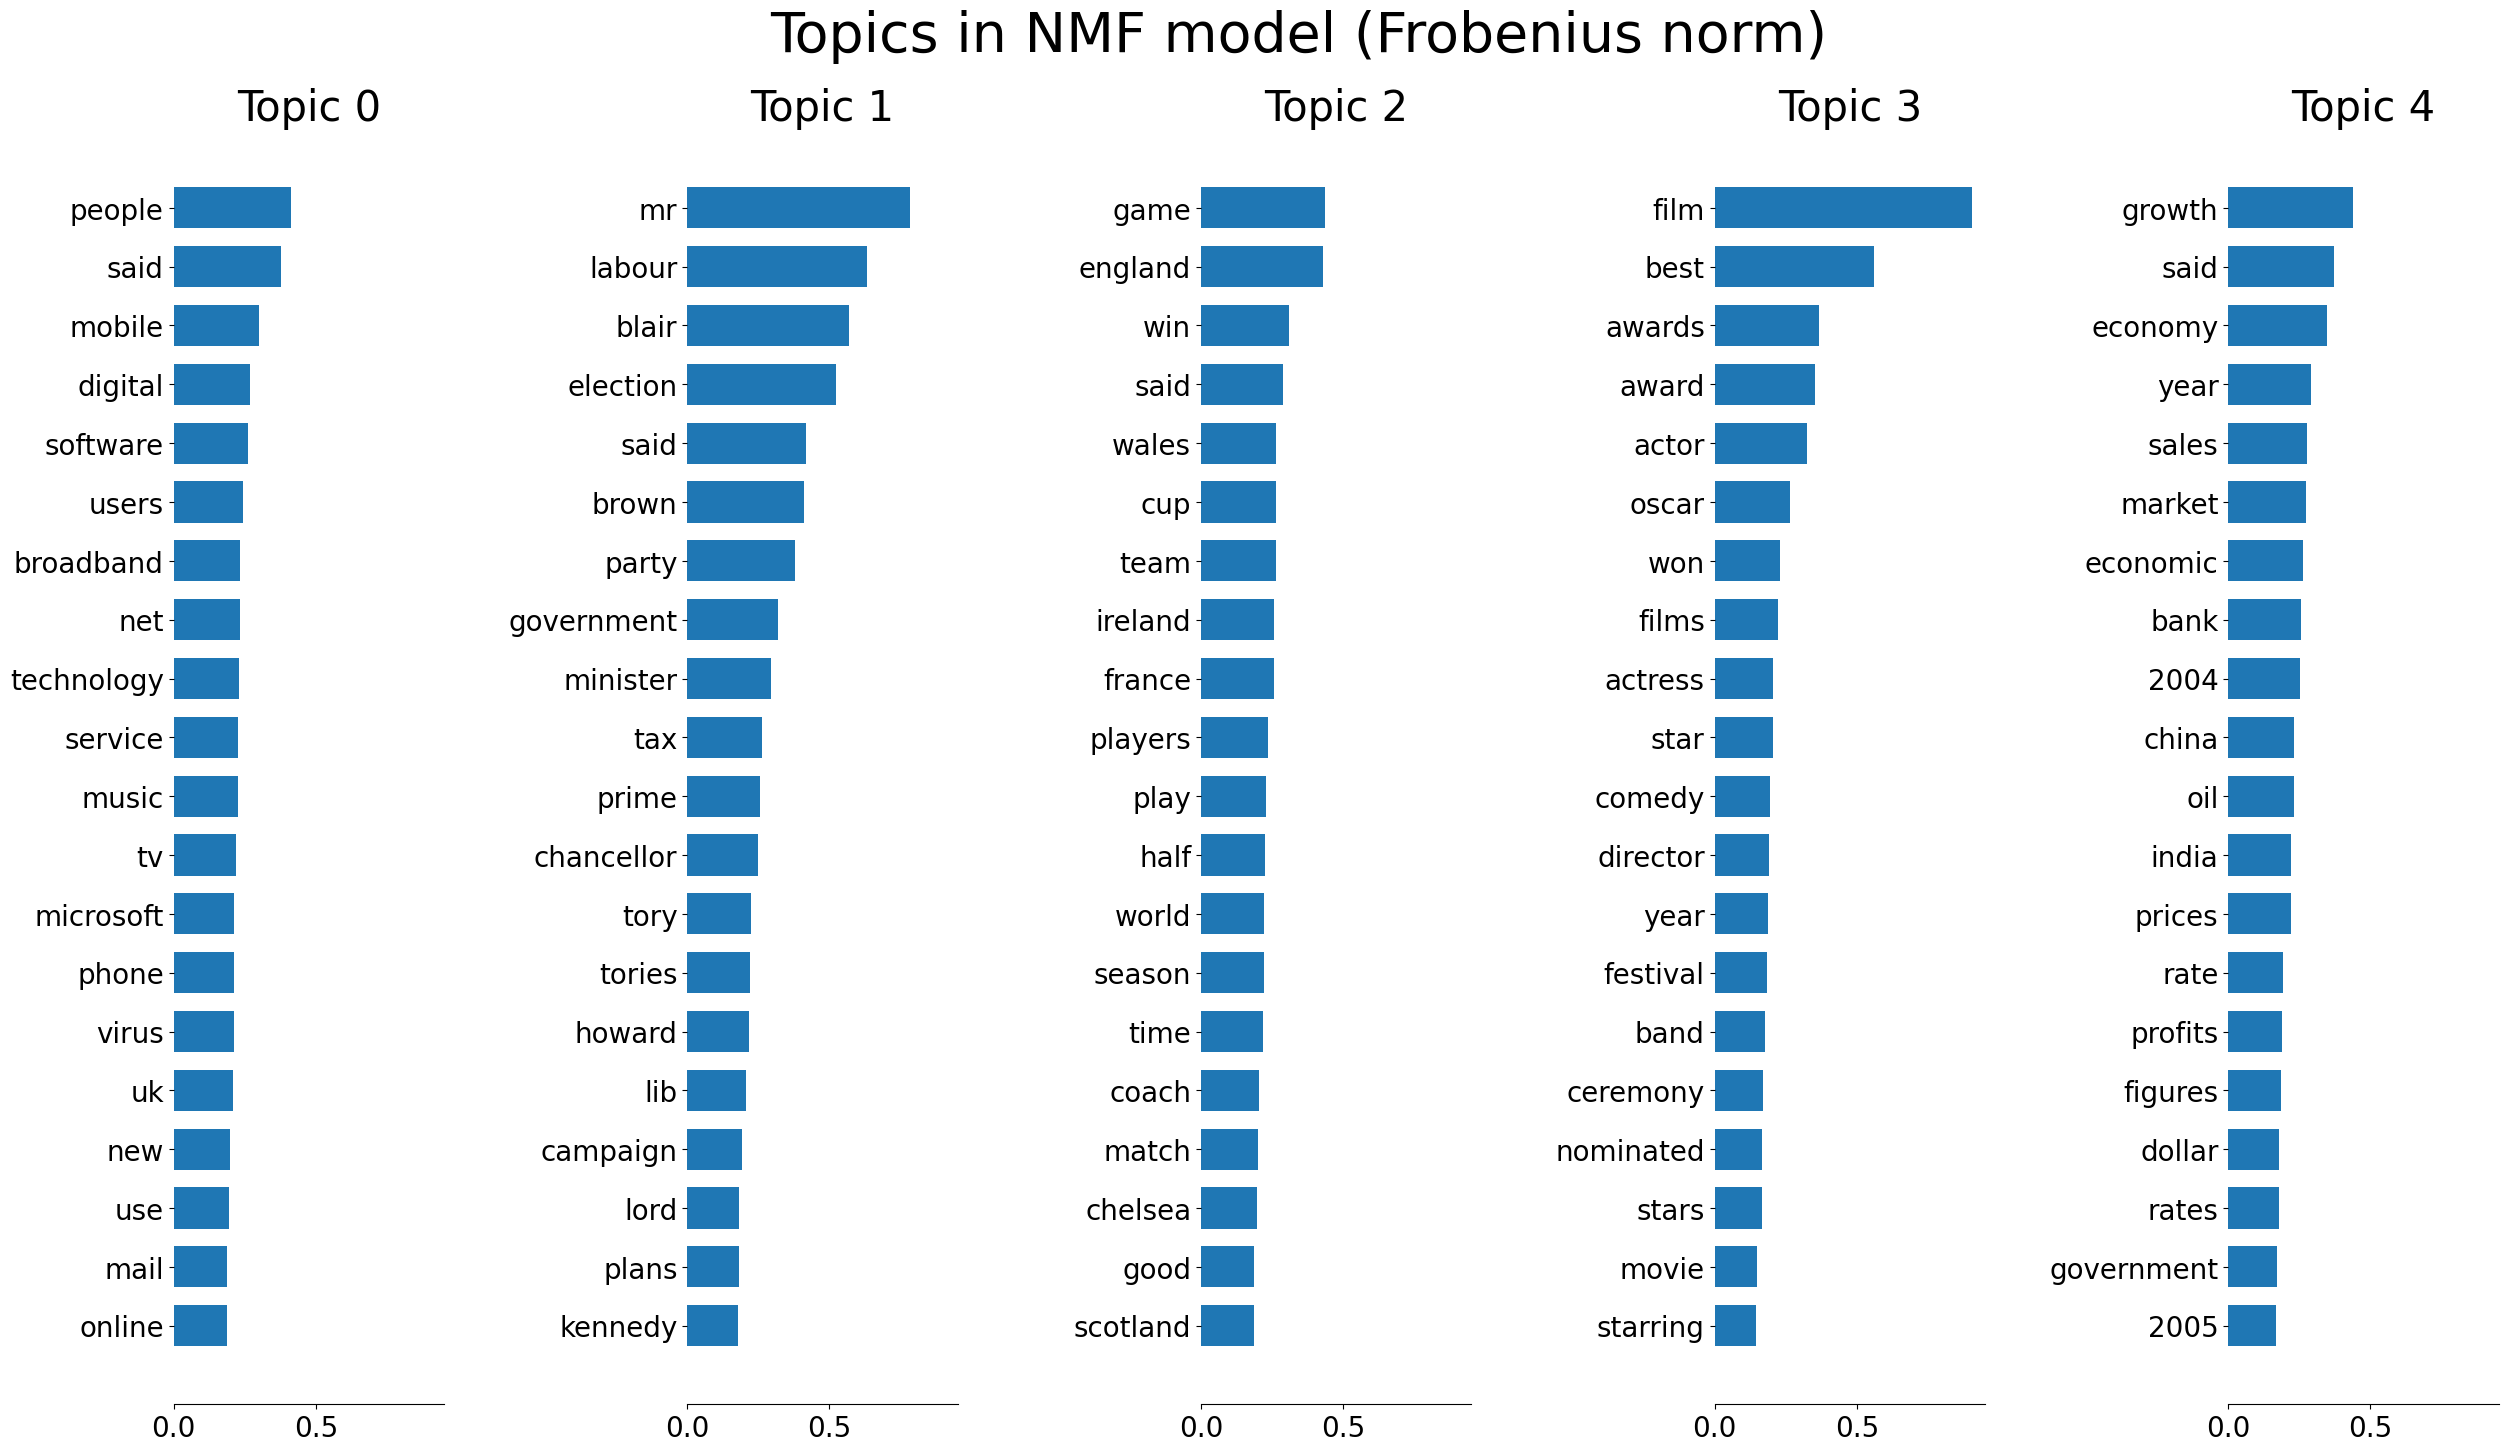

In [23]:
tfidf_feature_names = tfidf_vectorizer_train.get_feature_names_out()
plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)"
)

<hr><p>Using the above plot of most common words in each category, we can assign the categories to each topic found by the unsuperviused learning model.</p><hr>

In [24]:
category_dict = {0: 'tech', 1: 'politics', 2: 'sport', 3: 'entertainment', 4: 'business'}

<h3>Measure the performances on predictions from both train and test datasets. You can use accuracy, confusion matrix, etc., to inspect the performance. You can get accuracy for the test data by submitting the result to Kaggle</h3>

<hr><p>Now that we have the tfidf vectorizer and the NMF model, we can start testing the predictive power of the model.</p><p>Using the above dictionary and the scoring function below, we can assess the accuracy of the model predictions.</p><p>score_predictions() works by taking the weight (W) array generated by the nmf model, getting the index of the largest value in a given row, then pluging that index into the dictionary generated above to get the word for the category it was assigned to. We treat the largest value of a given sample (row) as an indicator of highest probability, which is why we are only interested in the largest of all values.</p><hr>

In [38]:

_str = 'pred_vals:', 'x', 'y', 'z'
cust_print(_str, sep= ' * ')

In [32]:
show_prints = False
def cust_print(_str_in, sep=' ', end='\n'):
    if show_prints == True:
        print(*_str_in, sep=sep, end=end)
        
def score_predictions(input_W, input_array, in_category_dict):
    
    pred_vals = np.array([np.argmax(row) for row in input_W])
    cust_print(['pred_vals:', pred_vals[:10]])
    cust_print(['pred_vals > 4:', pred_vals[pred_vals > 4]])
    cust_print(['pred_vals len:', len(pred_vals)])
    cust_print(['input_array len:', len(input_array)])
    #cust_print('input_array len:', len(input_array)])
    cust_print(['in_category_dict:', in_category_dict])
    pred_val_categories = [in_category_dict[ind] for ind in pred_vals]
    
    _score = np.mean(pred_val_categories == input_array)

    return _score

def calc_preds(nmf_in, tfidf_train_in, tfidf_train_vec_in, category_map_in, X_validate_in, y_train_in, y_validate_in):
    '''
    nmf_W_train = nmf.transform(tfidf_train)

    tfidf_validate = tfidf_vectorizer_train.transform(X_validate)
    nmf_W_validate = nmf.transform(tfidf_validate)
    
    _score_train = score_predictions(nmf_W_train, y_train, category_dict)
    _score_validate = score_predictions(nmf_W_validate, y_validate, category_dict)
    '''

    nmf_W_train = nmf_in.transform(tfidf_train_in)

    tfidf_validate = tfidf_train_vec_in.transform(X_validate_in)
    nmf_W_validate = nmf_in.transform(tfidf_validate)
    
    _score_train = score_predictions(nmf_W_train, y_train_in, category_map_in)
    _score_validate = score_predictions(nmf_W_validate, y_validate_in, category_map_in)

    return [_score_train, _score_validate]

def display_preds(nmf_in, tfidf_train_in, tfidf_train_vec_in, category_map_in, X_validate_in, y_train_in, y_validate_in):

    scores = calc_preds(nmf_in, tfidf_train_in, tfidf_train_vec_in, category_map_in, X_validate_in, y_train_in, y_validate_in)
    
    print(f'Training accuracy score: {scores[0]}')
    print(f'Validate accuracy score: {scores[1]}')

In [33]:
show_prints= True
display_preds(nmf, tfidf_train, tfidf_vectorizer_train, category_dict, X_validate, y_train, y_validate)
show_prints= False


pred_vals: [2 0 2 1 4 0 0 4 2 2]
pred_vals > 4: []
pred_vals len: 998
input_array len: 998
in_category_dict: {0: 'tech', 1: 'politics', 2: 'sport', 3: 'entertainment', 4: 'business'}
pred_vals: [3 1 2 1 2 4 4 0 3 4]
pred_vals > 4: []
pred_vals len: 492
input_array len: 492
in_category_dict: {0: 'tech', 1: 'politics', 2: 'sport', 3: 'entertainment', 4: 'business'}
Training accuracy score: 0.9118236472945892
Validate accuracy score: 0.9065040650406504


<hr><p>We can see that the model does quite well with the training data and the validation data.</p><hr>

<hr><p>Now, to get the true measure of the models predictive capabilities, a solution file generated from the model is submitted to Kaggle.</p><p>Below you will find the function used to create the solution file and an image showing the resulting score as given by Kaggle.</p><hr>

In [34]:

def convert_w_to_category(input_W, in_category_dict):
    pred_vals = np.array([np.argmax(row) for row in input_W])
    pred_val_categories = [in_category_dict[ind] for ind in pred_vals]

    return pred_val_categories
    
def export_submission(preds, file_name):
    df = df_solution
    df['Category'] = preds
    df.to_csv(file_name, index=False)
'''
preds = convert_w_to_category(nmf_W_test, category_dict)
export_submission(preds, 'test_predictions.csv')
'''

"\npreds = convert_w_to_category(nmf_W_test, category_dict)\nexport_submission(preds, 'test_predictions.csv')\n"

![title](kaggle_submission_score.png) 

<hr><p>Now we see that the trained nmf model does quite well at putting the articles in the test data into the correct categories, very comprable to the training and validation prediction scores.</p><hr>

<h3>Change hyperparameter(s) and record the results. We recommend including a summary table and/or graphs.</h3>

In [35]:
tfidf_inputs_12gram = {'max_df':0.95, 'min_df':2, 'max_features':n_features, 'stop_words':"english", "ngram_range": (1, 2)}
tfidf_vectorizer_12gram = TfidfVectorizer(**tfidf_inputs_12gram)
tfidf_train_12gram = tfidf_vectorizer_12gram.fit_transform(X_train)

nmf_12gram = NMF(**nmf_inputs).fit(tfidf_train_12gram)

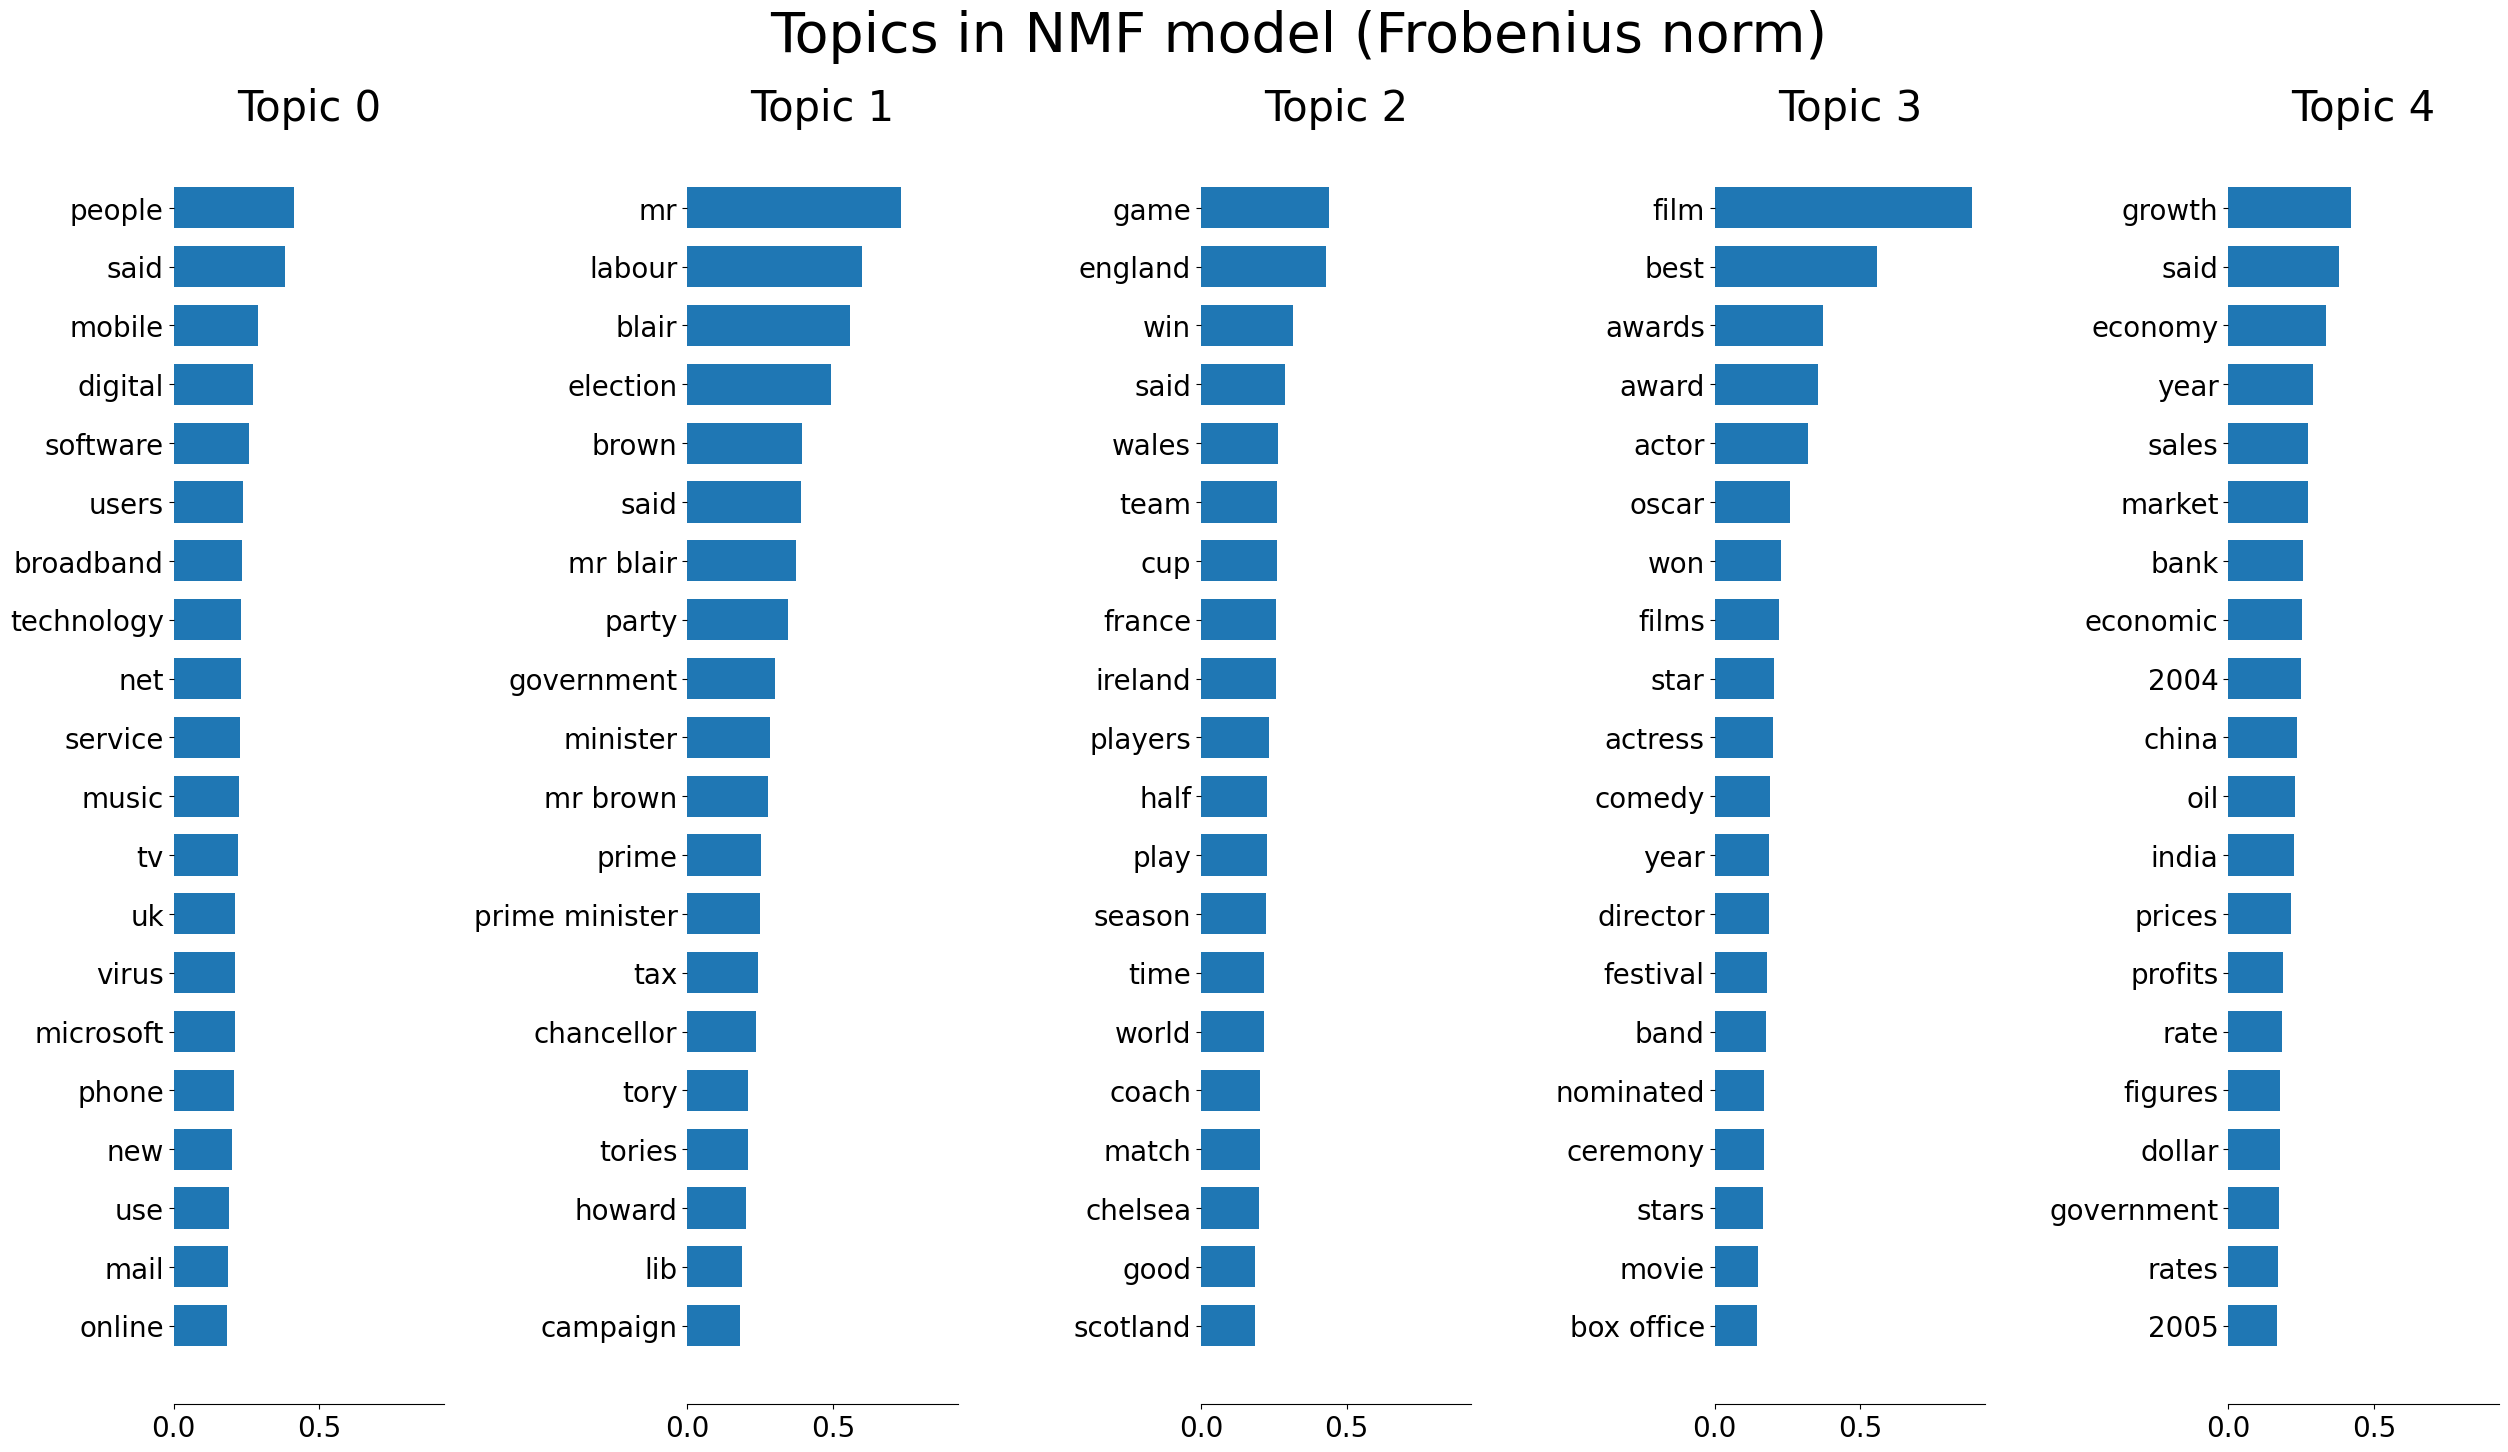

In [36]:
tfidf_feature_names_12gram = tfidf_vectorizer_12gram.get_feature_names_out()
plot_top_words(
    nmf_12gram, tfidf_feature_names_12gram, n_top_words, "Topics in NMF model (Frobenius norm)"
)

In [39]:
category_dict_12gram = {0: 'tech', 1: 'politics', 2: 'sport', 3: 'entertainment', 4: 'business'}

display_preds(nmf_12gram, tfidf_train_12gram, tfidf_vectorizer_12gram, category_dict_12gram, X_validate, y_train, y_validate)

Training accuracy score: 0.905811623246493
Validate accuracy score: 0.9024390243902439


In [40]:
tfidf_inputs_12gram_kl = {'max_df':0.95, 'min_df':2, 'max_features':n_features, 'stop_words':"english", "ngram_range": (1, 2)}
tfidf_vectorizer_12gram_kl = TfidfVectorizer(**tfidf_inputs_12gram_kl)
tfidf_train_12gram_kl = tfidf_vectorizer_12gram_kl.fit_transform(X_train)

nmf_inputs = {'n_components':n_components, 'random_state':1, 'init':init, 'beta_loss':"kullback-leibler", "solver": 'mu', 'alpha_W':0.001, 'alpha_H':0.001}
nmf_12gram_kl = NMF(**nmf_inputs).fit(tfidf_train_12gram_kl)

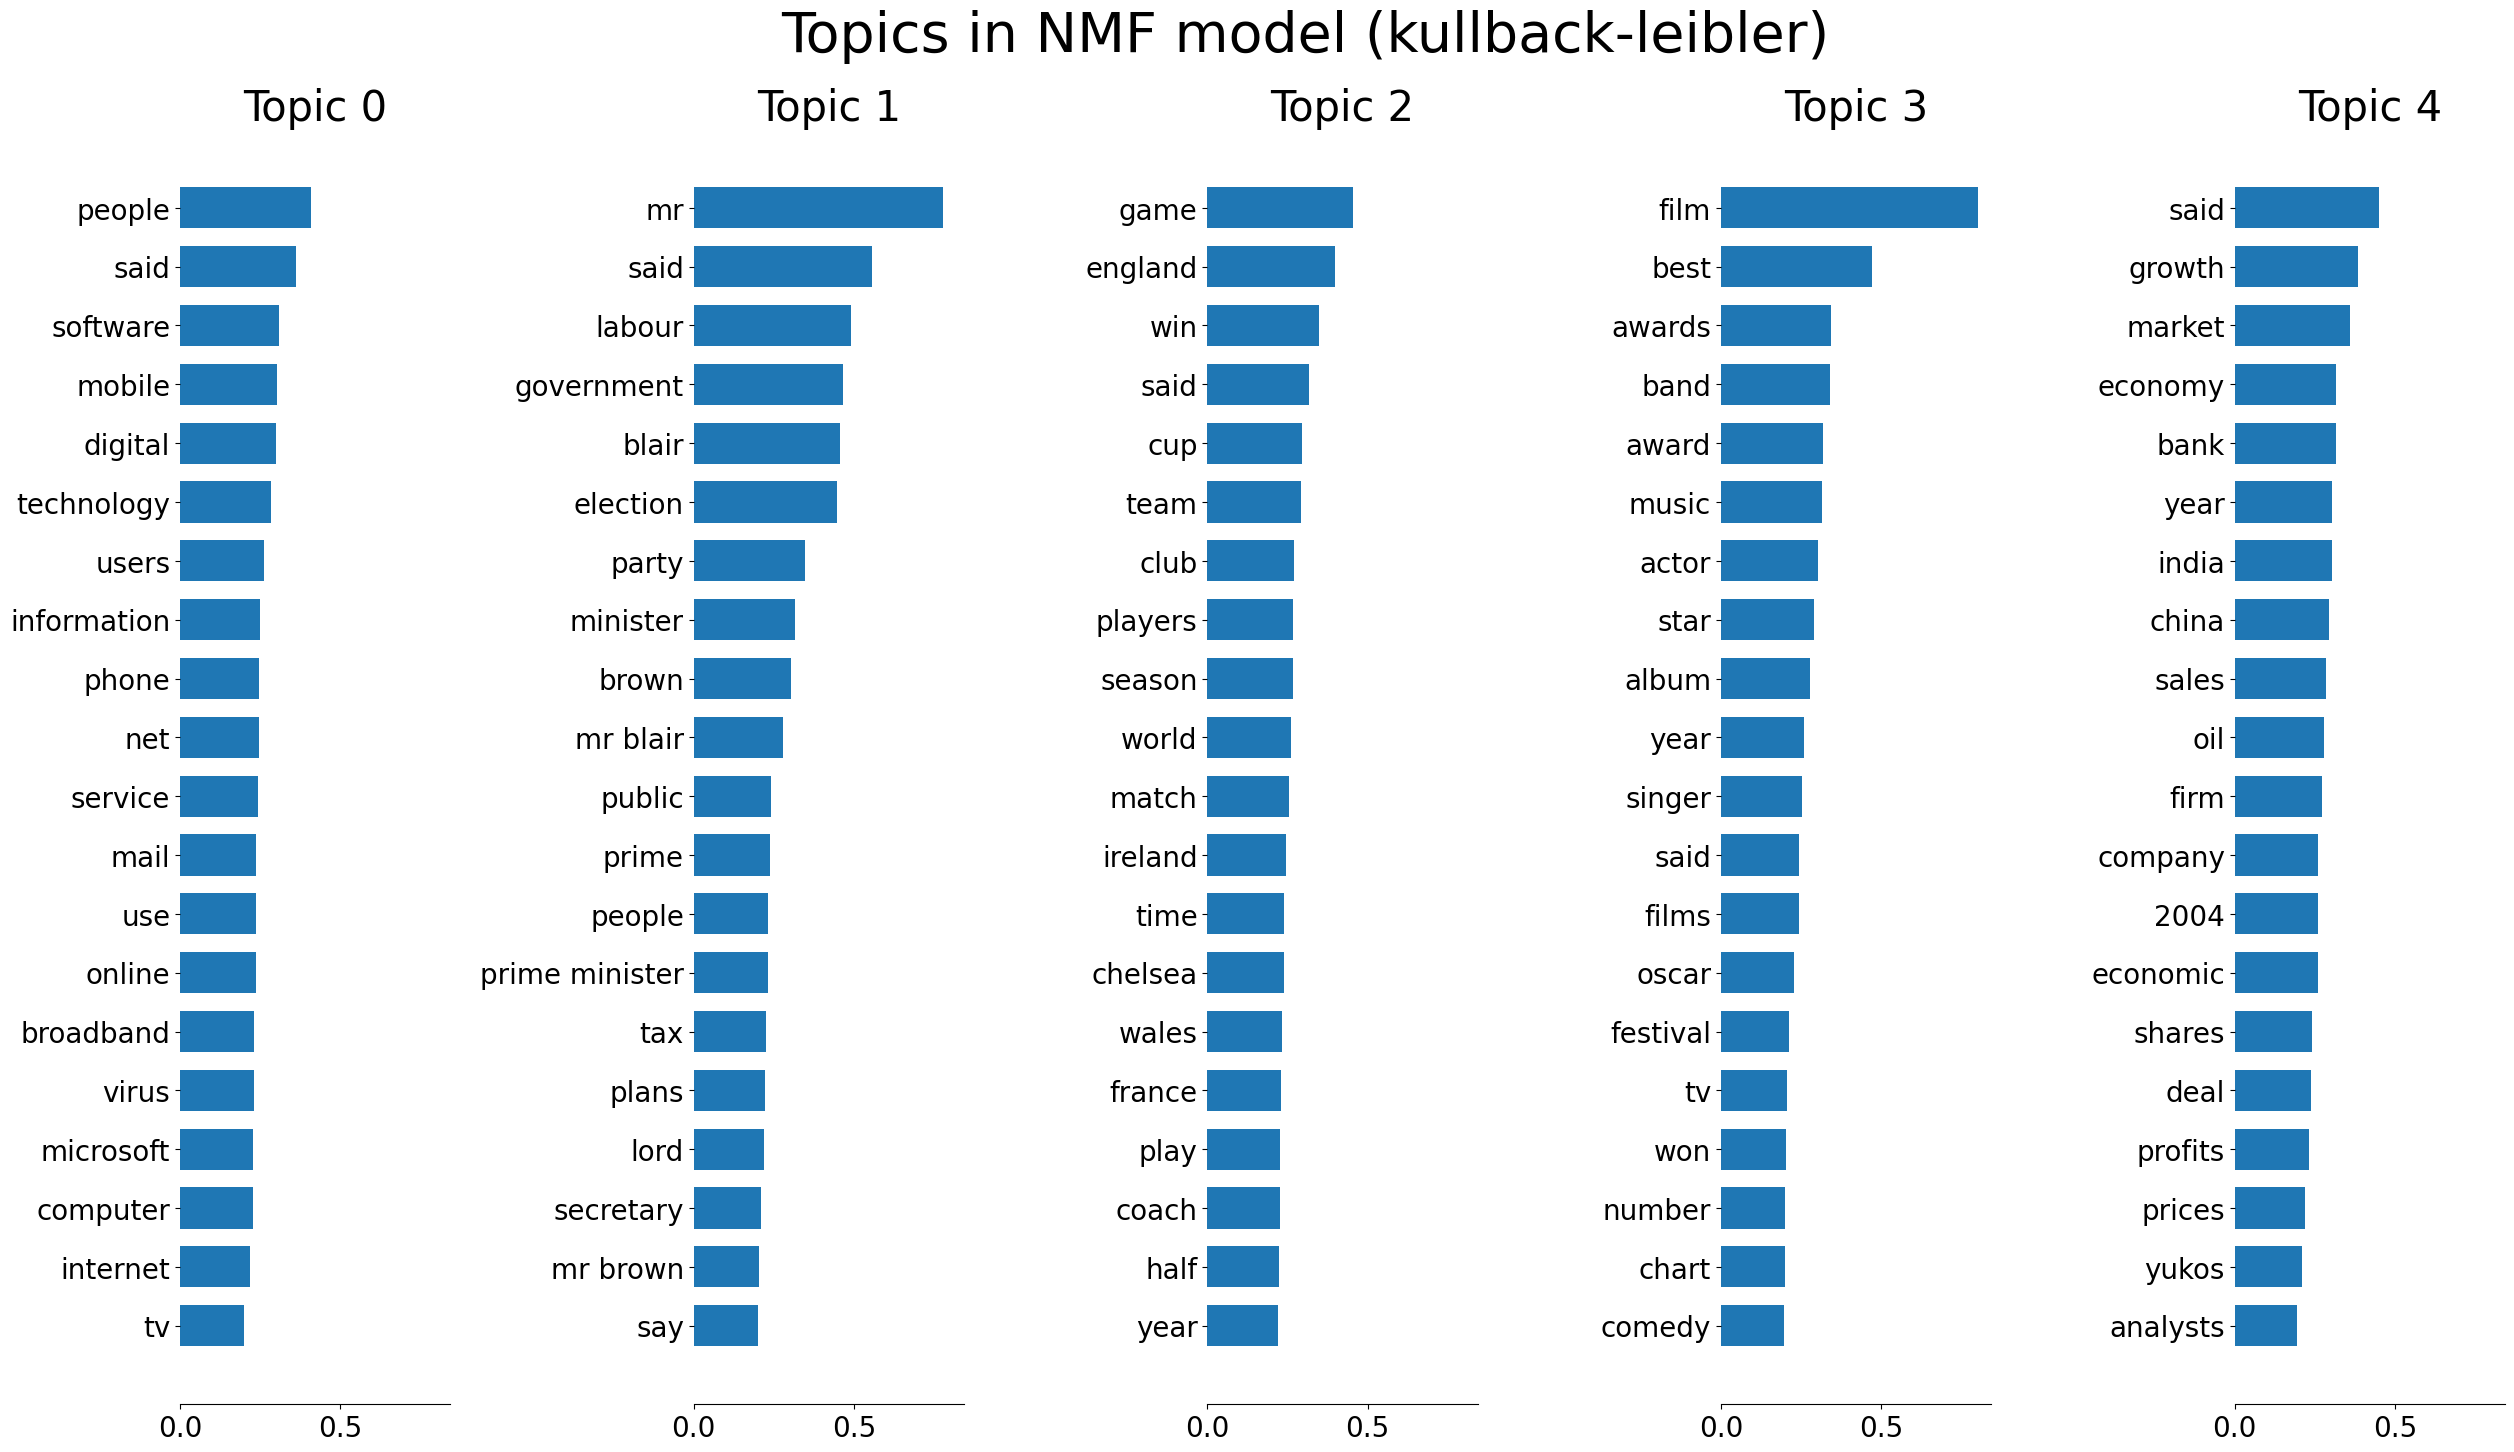

In [73]:
tfidf_feature_names_12gram_kl = tfidf_vectorizer_12gram_kl.get_feature_names_out()
plot_top_words(
    nmf_12gram_kl, tfidf_feature_names_12gram_kl, n_top_words, "Topics in NMF model (kullback-leibler)"
)

In [43]:
category_dict_12gram_kl = {0: 'tech', 1: 'politics', 2: 'sport', 3: 'entertainment', 4: 'business'}

display_preds(nmf_12gram_kl, tfidf_train_12gram_kl, tfidf_vectorizer_12gram_kl, category_dict_12gram_kl, X_validate, y_train, y_validate)

Training accuracy score: 0.9428857715430862
Validate accuracy score: 0.9471544715447154


<h3>Improve the model performance if you can- some ideas may include but are not limited to; using different feature extraction methods, fit models in different subsets of data, ensemble the model prediction results, etc. </h3>

In [44]:
parameter_grid_vec = {
        "max_df": (0.95,),
        #"max_df": (0.8, 0.9, 1.0),
        "min_df": (2,),
        #"min_df": (1, 2, 3),
        "max_features": (2000,),
        #"max_features": (500, 2000, 5000),
        "ngram_range": ((1, 1), (1, 2)),
        "stop_words": ("english", )
    }

parameter_grid_clf = {
        'n_components': (5, ),
        'random_state': (1, ),
        'init': ("nndsvda", ),
        'alpha_W': (0.001, ),
        #'alpha_W': (0.00005, 0.0005, 0.005, 0.05),
        'alpha_H': (0.001, ),
        'beta_loss': ("frobenius", "kullback-leibler"),
        'solver': ("cd", "mu"),
        #'alpha_H': (0.00005, 0.0005, 0.005, 0.05),
        #"l1_ratio": (0, 0.05, 1),
    }

In [45]:
def custom_fitter(parameter_grid_vec, parameter_grid_clf, X_train_in):
    
    arr_parameter_grid_vec = list(ParameterGrid(parameter_grid_vec))
    arr_parameter_grid_clf = list(ParameterGrid(parameter_grid_clf))
    arr_parameter_grid_clf = [param_set for param_set in arr_parameter_grid_clf if ([param_set['beta_loss'], param_set['solver']] != ['kullback-leibler', 'cd'])]
    _len_vec = len(arr_parameter_grid_vec)
    _len_clf = len(arr_parameter_grid_clf)
    
    arr_tfidf_vectorizer = ["" for i in range(_len_vec)]
    arr_tfidf_ft = ["" for i in range(_len_vec)]
    
    for count, param_set_vec in enumerate(arr_parameter_grid_vec):
        cust_print(['params for vec:', param_set_vec])
        tfidf_vectorizer = TfidfVectorizer(**param_set_vec).fit(X_train_in)
        arr_tfidf_vectorizer[count] = tfidf_vectorizer
        arr_tfidf_ft[count] = tfidf_vectorizer.transform(X_train_in)
        
    cust_print(['vectorizor construction complete'])
    
    arr_nmf_fit = ["" for i in range(_len_vec*_len_clf)]
    arr_nmf_transform = ["" for i in range(_len_vec*_len_clf)]
    
    for count_vec, tfidf_ft in enumerate(arr_tfidf_ft):
        for count_clf, param_set_clf in enumerate(arr_parameter_grid_clf):
            val_count = count_vec*len(arr_parameter_grid_clf) + count_clf
            cust_print(['params for clf:', param_set_clf])
            nmf = NMF(**param_set_clf).fit(tfidf_ft)
            arr_nmf_fit[val_count] = nmf
            arr_nmf_transform[val_count] = nmf.transform(tfidf_ft)
    
    cust_print(['nmf construction complete'])
    return {"vec_params":arr_parameter_grid_vec,
            "clf_params":arr_parameter_grid_clf,
            "tfidf_vecs":arr_tfidf_vectorizer,
            "tfidf_ft_vecs":arr_tfidf_ft,
            "fitted_nmfs":arr_nmf_fit, 
            "nmf_ws":arr_nmf_transform}

In [46]:
custom_fitter_returns = custom_fitter(parameter_grid_vec, parameter_grid_clf, X_train)

In [47]:
categories = df_train.Category.unique()
def create_category_to_topic_map(vec_params_in, clf_params_in, tfidf_vec_in, nmf_fit_in, 
                                 nmf_original, tfidf_feature_names_original, map_original):

    ### create dictinoary to store lists of most common words in categories
    cat_top_words_dict = {cat: [] for cat in categories}

    ### construct vectorizor
    #tfidf_vectorizer_map = TfidfVectorizer(**vec_params_in)
    n_top_words_test = 200
    
    '''
    for index, category in enumerate(categories):
        
        
        tfidf_for_category = tfidf_vectorizer_map.fit_transform(df_train[df_train.Category == category]['Text'])
        
        nmf_map = NMF(**clf_params_in).fit(tfidf_for_category)
        tfidf_vectorizer_map_feature_names = tfidf_vectorizer_map.get_feature_names_out()
        top_features_test = []
        
        #print('category:', category)

        #print(tfidf_vectorizer_map_feature_names[-n_top_words_test:])
        top_features_ind = nmf_map.components_[0].argsort()[-n_top_words_test:]
        cat_top_words_dict[category] = tfidf_vectorizer_map_feature_names[top_features_ind]
        
        #print(cat_dict[category])
    '''
    

    for topic_idx, topic in enumerate(nmf_original.components_):
        top_features_ind = topic.argsort()[-n_top_words_test:]
        cat_top_words_dict[ map_original[topic_idx] ] = tfidf_feature_names_original[top_features_ind]

    cat_dict = {cat: -1 for cat in categories}
    
    for _cat in categories:
        _category_words = cat_top_words_dict[_cat]
        cust_print(['\ntop _category:\n',_cat, '\n'])
        cust_print([f'_category_words {_cat}:\n',_category_words])
        input_features = tfidf_vec_in.get_feature_names_out()
        
        all_freq = [0,0,0,0,0]
        for i in range(len(all_freq)):
            input_top_features_ind = nmf_fit_in.components_[i].argsort()[-n_top_words_test:]
            top_words = input_features[input_top_features_ind]
            cust_print([f'top_words: {top_words}\n'])
            freq = np.array([1 if i in _category_words else 0 for i in top_words])
            cust_print([i, freq])
            #if np.mean(freq) > 0:
            #    print(]f'test_top_words for ind {i}:\n', top_words])
            #    print([freq])
            all_freq[i] = np.mean(freq)
        cust_print(['all_freq:', all_freq])
        max_feq_ind = np.argmax(all_freq)
        cat_dict[_cat] = [max_feq_ind, all_freq]

    return_dict = {key: val[0] for key, val in cat_dict.items()}
    check_vals = np.unique(np.array([val[0] for key, val in cat_dict.items()]))
    cust_print(check_vals)
    _vals = [i for i in range(5) if i not in check_vals]
    
    if check_vals.shape[0] != 5:

        cust_print(['\n\n    *****     checking    *****  \n\n'])        
        cust_print(['cat_dict:', cat_dict])
        cust_print(['return_dict:', return_dict])
        cust_print(['_vals:', _vals])
        
        _counts = [val[0] for key, val in cat_dict.items()]
        _counts = [i for i in range(5) if _counts.count(i) > 1]
        
        #cust_print('_counts:', _counts)

        to_check_cats = [key for key, val in cat_dict.items() if val[0] in _counts]
        to_check = [val[1] for key, val in cat_dict.items() if val[0] in _counts]

        check_counter = 1
        while len(to_check) > 1 and len(_vals) > 0:
            
            cust_print(['\n\n *****  iteration #:', check_counter, '\n'])
            cust_print(['to_check:', to_check])
            cust_print(['to_check_cats:', to_check_cats])
            
            max_args = [np.argmax(i) for i in to_check]
            max_vals = [to_check[i][max_args[i]] for i in range(len(max_args))]
            
            cust_print(['max_args:', max_args])
            cust_print(['max_vals:', max_vals])
            
            
            for i in range(len(max_args)):
                to_check[i][max_args[i]] = 0
            
            
            cust_print(['to_check_new:', to_check])
            
            max_args_new = [np.argmax(i) for i in to_check]
            max_vals_new = [to_check[i][max_args_new[i]] for i in range(len(max_args_new))]
            max_vals_diff = [max_vals[i] - max_vals_new[i] for i in range(len(max_vals_new))]
            
            cust_print(['max_args_new:', max_args_new])
            cust_print(['max_vals_new:', max_vals_new])
            cust_print(['max_vals_diff:', max_vals_diff])
            
            max_diff_arg = np.argmax(max_vals_diff)
            
            cust_print(['max_diff_arg:', max_diff_arg])
            
            del to_check[max_diff_arg]
            del max_args_new[max_diff_arg]
            del to_check_cats[max_diff_arg]
            
            cust_print(['to_check_final:', to_check])
            cust_print(['max_args_final:', max_args_new])
            cust_print(['to_check_cats_final:', to_check_cats])

            if len(max_args_new) == 1 and len(_vals) == 1:
                cust_print(['max_args_new len == 1 and _vals len == 1'])
                return_dict[to_check_cats[0]] = _vals[0]
            else:
                cust_print(['max_args_new len > 1 or _vals len > 1'])
                for i in range(len(max_args_new)):
                    if max_args_new[i] not in _vals:
                        return_dict[to_check_cats[i]] = max_args_new[i]
            
            #print('return_dict:', return_dict)
            check_vals = np.unique(np.array([val for key, val in return_dict.items()]))
            _vals = [i for i in range(5) if i not in check_vals]
            check_counter += 1
        
        '''
        for key, val in cat_dict.items():
            for key_2, val_2 in cat_dict.items():
                if val[0] == val_2[0] and key != key_2:
                    if val[1] >= val_2[1]:
                        return_dict[key] = val[0]
                        return_dict[key_2] = _vals[0]
                    else:
                        return_dict[key] = _vals[0]
                        return_dict[key_2] = val_2[0]
        '''
    check_vals = np.unique(np.array([val for key, val in return_dict.items()]))
    if check_vals.shape[0] != 5:
        cust_print(["ERROR:", check_vals, all_freq, 'end Error'], sep='\n\n')
        

    return_dict = {val: key for key, val in return_dict.items()}
    '''
    del cat_top_words_dict
    del tfidf_vectorizer_map
    del nmf_map
    del tfidf_for_category
    del top_features_test
    del tfidf_vectorizer_map_feature_names
    del top_features_ind
    del _category_words
    del input_features
    del input_top_features_ind
    del top_words
    del freq
    del cat_dict
    del check_vals
    '''
    cust_print([return_dict])
    cust_print(['run finished\n'])
    
    return return_dict

def creat_dictionarys(custom_fitter_returns_in):

    vec_params = custom_fitter_returns_in['vec_params']
    clf_params = custom_fitter_returns_in['clf_params']
    all_dict = ['' for i in range(len(vec_params)*len(clf_params))]
    all_nmf = ['' for i in range(len(vec_params)*len(clf_params))]
    
    for vec_count, vec_param in enumerate(vec_params):
        
        tfidf_vec = custom_fitter_returns_in['tfidf_vecs'][vec_count]
        if vec_param['ngram_range'] == (1,1):
            nmf_in = nmf
            tfidf_feature_names_in = tfidf_feature_names
            _nmf = 'nmf'
            category_dict_in = category_dict
        else:
            cust_print('12_grams')
            nmf_in = nmf_12gram
            tfidf_feature_names_in = tfidf_feature_names_12gram
            _nmf = 'nmf_12_gram'
            category_dict_in = category_dict_12gram
            
        for clf_count, clf_param in enumerate(clf_params):
            
            val_count = vec_count*len(clf_params) + clf_count
            cust_print(['\n     val_count:', val_count, '\n'])
            nmf_fit = custom_fitter_returns_in['fitted_nmfs'][val_count]
            _map = create_category_to_topic_map(vec_param, clf_param, tfidf_vec, nmf_fit,
                                                                nmf_in, tfidf_feature_names_in, category_dict_in)
             
            all_dict[val_count] = _map
            all_nmf[val_count] = _nmf
            
    return [all_dict, all_nmf]

In [48]:

test_index = 3

#return_dict = create_category_to_topic_map(custom_fitter_returns['vec_params'][0], 
#                                           custom_fitter_returns['clf_params'][0], 
#                                           custom_fitter_returns['tfidf_vecs'][0], 
#                                           custom_fitter_returns['fitted_nmfs'][0],
#                                           nmf, tfidf_feature_names, category_dict)
#print(return_dict)
[all_dict, all_nmf] = creat_dictionarys(custom_fitter_returns,)
display(all_dict)
display(all_nmf)

[{4: 'business', 0: 'tech', 2: 'politics', 1: 'sport', 3: 'entertainment'},
 {4: 'business', 0: 'tech', 2: 'politics', 1: 'sport', 3: 'entertainment'},
 {4: 'business', 0: 'tech', 2: 'politics', 1: 'sport', 3: 'entertainment'},
 {4: 'business', 0: 'tech', 1: 'politics', 2: 'sport', 3: 'entertainment'},
 {4: 'business', 0: 'tech', 1: 'politics', 2: 'sport', 3: 'entertainment'},
 {4: 'business', 0: 'tech', 1: 'politics', 2: 'sport', 3: 'entertainment'}]

['nmf', 'nmf', 'nmf', 'nmf_12_gram', 'nmf_12_gram', 'nmf_12_gram']

In [49]:
def calc_scores_all(all_maps_in, arr_in, X_validate_in, y_train_in, y_validate_in):
    _len = len(all_maps_in) 
    cust_print(['all_maps_in len:', _len])
    _len_vec = len(arr_in['vec_params'])
    _len_clf = len(arr_in['clf_params'])
    all_scores = [[] for i in range(_len)]
    df1 = pd.DataFrame()
    
    for vec_count in range(_len_vec):
        for clf_count in range(_len_clf):
            
            count_tot = vec_count*_len_clf + clf_count
            cust_print(['count_tot:', count_tot])
            nmf = arr_in['fitted_nmfs'][count_tot]
            tfidf_train = arr_in['tfidf_ft_vecs'][vec_count]
            tfidf_vectorizer_train = arr_in['tfidf_vecs'][vec_count]
            _vec_dict = {f"tfidf_{key}": val for key, val in arr_in['vec_params'][vec_count].items()}
            _model_dict = {f"nmf_{key}": val for key, val in arr_in['clf_params'][clf_count].items()}
            full_params = {**_vec_dict, **_model_dict}
            full_params['tfidf_ngram_range'] = str(full_params['tfidf_ngram_range'])
            #cust_print([f"vectorizer params: {arr_in['vec_params'][vec_count]},\nmodel params: {arr_in['clf_params'][clf_count]}"])
            
            #cust_print([f"full set: {full_params}"])
            cust_print(['calc_scores_all y_train_in:', y_train_in.shape, 'calc_scores_all y_validate_in:', y_validate_in.shape])
            scores = calc_preds(nmf, tfidf_train, tfidf_vectorizer_train, all_maps_in[count_tot], X_validate_in, y_train_in, y_validate_in)
            #cust_print(['\n'])
            df = pd.DataFrame({'train_score': scores[0], 'validate_score': scores[1],**full_params}, index=[count_tot])
            df1 = pd.concat([df1, df], ignore_index=True)
    return df1

In [50]:
scores_df = calc_scores_all(all_dict, custom_fitter_returns, X_validate, y_train, y_validate)

In [51]:
scores_df = calc_scores_all(all_dict, custom_fitter_returns, X_validate, y_train, y_validate)
cols_to_remove = ['tfidf_max_df', 'tfidf_max_features','tfidf_min_df', 'tfidf_stop_words', 'nmf_alpha_H', 'nmf_alpha_W', 'nmf_init', 'nmf_n_components', 'nmf_random_state']

df_constants = scores_df[cols_to_remove].drop_duplicates()
scores_df = scores_df.drop(cols_to_remove, axis=1)
display(scores_df.sort_values(by=['train_score'], ascending=False))
display(df_constants)

,train_score,validate_score,tfidf_ngram_range,nmf_beta_loss,nmf_solver
5,0.949900,0.953252,"(1, 2)",kullback-leibler,mu
2,0.945892,0.951220,"(1, 1)",kullback-leibler,mu
0,0.911824,0.910569,"(1, 1)",frobenius,cd
3,0.902806,0.906504,"(1, 2)",frobenius,cd
1,0.884770,0.894309,"(1, 1)",frobenius,mu
4,0.877756,0.884146,"(1, 2)",frobenius,mu


,tfidf_max_df,tfidf_max_features,tfidf_min_df,tfidf_stop_words,nmf_alpha_H,nmf_alpha_W,nmf_init,nmf_n_components,nmf_random_state
0,0.95,2000,2,english,0.001,0.001,nndsvda,5,1


<h2>Part 3:<p></p>Compare with supervised learning</h2>

<h3>Pick and train a supervised learning method(s) and compare the results (train and test performance)</h3>

In [52]:
from sklearn.linear_model import LogisticRegression
def get_vals(test_perc, rand_state=0):
    X_train, X_validate, y_train, y_validate = train_test_split(df_train['Text_clean'].values, df_train['Category'].values, test_size=test_perc, random_state=rand_state)
    return [X_train, X_validate, y_train, y_validate]
[X_train, X_validate, y_train, y_validate] = get_vals(test_perc=0.33)

In [53]:
vectorizer = CountVectorizer()
cv_train_fit_tansform = vectorizer.fit_transform(X_train)
cv_validate_tansform = vectorizer.transform(X_validate)

classifier = LogisticRegression()
classifier.fit(cv_train_fit_tansform, y_train)

y_pred = classifier.predict(cv_validate_tansform)

test_tansform = vectorizer.transform(final_test)
y_test_pred = classifier.predict(test_tansform)

C:\Users\kgrit\OneDrive\Documents\UC boulder Data science masters\Unsupervised learning\week 4\jup ntbk work\week4venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [54]:
accuracy = accuracy_score(y_validate, y_pred)
print("Accuracy:", accuracy)
#df_logit = pd.DataFrame({ 'y_pred': y_pred,'y_validate': y_validate, 'match?': y_validate==y_pred})
#display(df_logit[:20])

Accuracy: 0.9634146341463414


<hr>Here we see that without any optimization of parameters, the logistic regression model can be quite accurate, more accurate - by about 1% - than the unsupervised learning model.<hr>

In [626]:
#export_submission(y_test_pred, 'logit_reg_test_predictions.csv')

![title](kaggle_submission_score_logit.png) 

<hr>Here we see that the logistic regression model did better in the final test than the nmf model<hr>

<h3>Discuss comparison with the unsupervised approach. You may try changing the train data size (e.g., Include only 10%, 20%, 50% of labels, and observe train/test performance changes). Which methods are data-efficient (require a smaller amount of data to achieve similar results)? What about overfitting?</h3>

<hr><p>From my own work on this assignment, it is quite suprising that the non-zero matrix factorization method, with a few tweeks, is able to properly categorize articles based solely on their word contents almost as well as a supervised learning algorithm that is given the anser categories to train on. It takes more work perhaps to determine if the unsupervised learning algorithm is using the optimum parameters, and of course an answer set to truly determine its effectiveness at correct categorization, but still quite amazing.</p>
<p>To get a sense of how the model accuracy changes with training sample size for each model, we'll train a model using each percentage of total data as training data given above.</p><p>First we train the logistic regression models and determine their accuracy scores</p><hr>

In [55]:
train_perc = [0.05, 0.1, 0.2, 0.33, 0.5, 0.66]
acc_train_arr = [0 for i in train_perc]
acc_val_arr = [0 for i in train_perc]
for i in range(len(train_perc)):
    
    [X_train_logit, X_validate_logit, y_train_logit, y_validate_logit] = get_vals(test_perc=1-train_perc[i])
    vectorizer = CountVectorizer()
    X_train_fit_tansform = vectorizer.fit_transform(X_train_logit)
    X_validate_tansform = vectorizer.transform(X_validate_logit)
    
    classifier = LogisticRegression()
    classifier.fit(X_train_fit_tansform, y_train_logit)

    #y_pred_train = classifier.predict(X_train_fit_tansform)
    y_pred_validate = classifier.predict(X_validate_tansform)

    #acc_train_arr[i] = accuracy_score(y_train_logit, y_pred_train)
    acc_val_arr[i] = accuracy_score(y_validate_logit, y_pred_validate)

C:\Users\kgrit\OneDrive\Documents\UC boulder Data science masters\Unsupervised learning\week 4\jup ntbk work\week4venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\kgrit\OneDrive\Documents\UC boulder Data science masters\Unsupervised learning\week 4\jup ntbk work\week4venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/m

<hr>Now to create the models for the unsupervised NMF model, using the optimum prameters found previously<hr>

In [56]:
p_grid_vec_2 = {
        "max_df": (0.95,),
        "min_df": (2,),
        "max_features": (2000,),
        "ngram_range": ((1, 2), ),
        "stop_words": ("english", )
    }

p_grid_clf_2 = {
        'n_components': (5, ),
        'random_state': (1, ),
        'init': ("nndsvda", ),
        'alpha_W': (0.001, ),
        'alpha_H': (0.001, ),
        'beta_loss': ("kullback-leibler", ),
        'solver': ("mu", )
    }

In [57]:
cf_returns_2 = ['' for i in train_perc]
data_use_later = [[] for i in train_perc]
for i in range(len(train_perc)):
    [X_train_nmf, X_validate_nmf, y_train_nmf, y_validate_nmf] = get_vals(test_perc=1-train_perc[i], rand_state=0)
    data_use_later[i] = [X_validate_nmf, y_train_nmf, y_validate_nmf]
    cf_returns_2[i] = custom_fitter(p_grid_vec_2, p_grid_clf_2, X_train_nmf)

In [58]:
all_maps_final = ['' for i in train_perc]

for i in range(len(train_perc)):

    cust_print([cf_returns_2[i]['vec_params'], cf_returns_2[i]['clf_params']], sep='\n')
    cust_print([f'   *** calc {i} ***   '])
    [_dict, all_nmf] = creat_dictionarys(cf_returns_2[i])
    all_maps_final[i] = _dict

#display(all_maps_final)

In [59]:
df_arr = ['' for i in train_perc]
for i in range(len(train_perc)):
    #print(cf_returns_2[i])
    [X_validate_nmf_score, y_train_nmf_score, y_validate_nmf_score] = data_use_later[i]
    #print(X_train_nmf_score.shape, X_validate_nmf_score.shape, y_train_nmf_score.shape, y_validate_nmf_score.shape)
    df_arr[i] = calc_scores_all(all_maps_final[i], cf_returns_2[i], X_validate_nmf_score, y_train_nmf_score, y_validate_nmf_score)
    df_arr[i].insert(0, 'train precent', train_perc[i]) 
    df_arr[i].insert(1, 'test precent', 1 - train_perc[i]) 


In [60]:
#print(df_arr)
df_final = pd.DataFrame()

for i in range(len(df_arr)):
    df_final = pd.concat([df_final, df_arr[i]], ignore_index=True)
    
cols_to_focus = ['train precent', 'test precent','train_score', 'validate_score']

df_constants_final = df_final.drop(cols_to_focus, axis=1)
df_constants_final = df_constants_final.drop_duplicates()
df_final = df_final[cols_to_focus]
#display(df_final)
#display(df_constants_final)

<hr>Finally, we'll plot the scores of each model as a function of their training data sample size and see how their accuracies compare. The y-axis for the plots are shared to give a better visual representation of their relative accuracies.<hr>

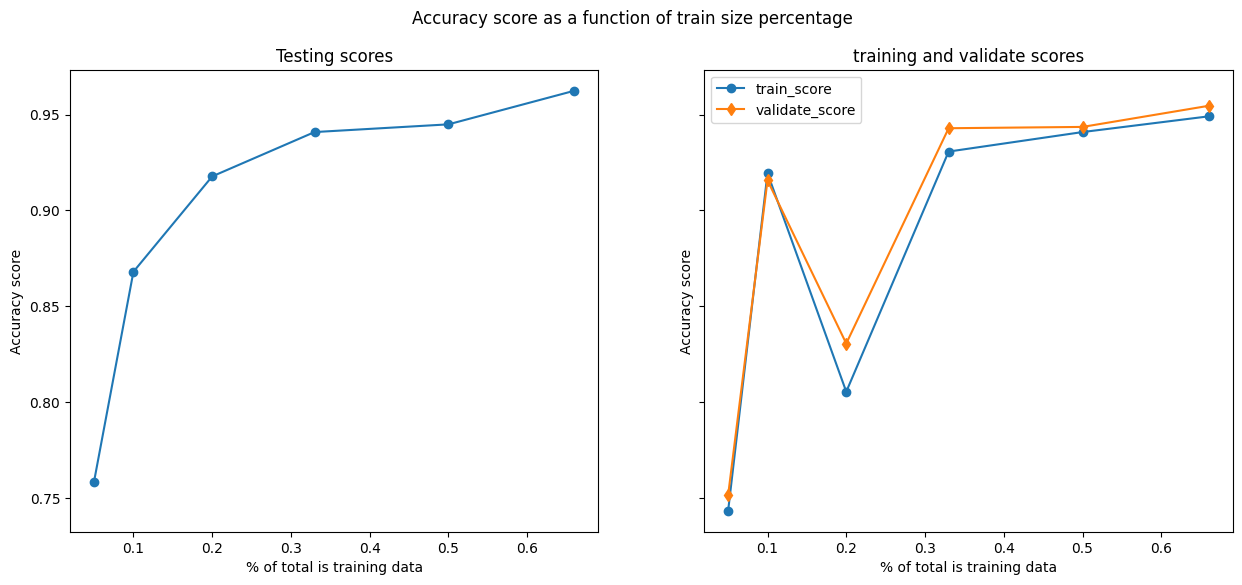

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

ax1.plot(train_perc, acc_val_arr, 'o-')
#plt.plot(train_perc, acc_train_arr, 'd-')
ax1.set_xlabel('% of total is training data')
ax1.set_ylabel('Accuracy score')
ax1.set_title('Testing scores')

ax2.plot(train_perc, df_final['train_score'], 'o-')
ax2.plot(train_perc, df_final['validate_score'], 'd-')
ax2.legend(['train_score', 'validate_score'])
ax2.set_xlabel('% of total is training data')
ax2.set_ylabel('Accuracy score')
ax2.set_title('training and validate scores')
fig.suptitle('Accuracy score as a function of train size percentage')
plt.show()

<hr>If not for the sudden dip in accuracy for the nmf model at train_size = 20%, the non-zero matrix facotization models would have performed better than the logistic regression models. As a side, when changing the random_state for the test_train_split_function, this sudden drop does not appear. For the sake of runtime, I will not show this explicitly but you can change the random_state value yourself if you wish.<hr>

<h3>References</h3>
<span>[<a href="#id01">1</a>]</span>
<p>Harsh Singh. <a href='https://www.kaggle.com/code/harshsingh2209/complete-guide-to-eda-on-text-data/notebook'>"Complete Guide to EDA on Text Data".</a></p>
<span>[<a href="#id02">2</a>]</span>
<p>Olivier Grisel, Lars Buitinck, Chyi-Kwei Yau. <a href="https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py">"Topic extraction with Non-negative Matrix Factorization and Latent Dirichlet Allocation"</a></p>